In [9]:
import numpy as np
import pandas as pd
import datetime
import time
import yaml

from sklearn.preprocessing import StandardScaler
from pathlib import Path

# from utils import Timer, seed_everything
# from utils import DataLoader, Yml, make_submission
# from utils import send_line, send_notion
# from runner import train_and_predict, save_importances, save_oof_plot, save_learning_curve

import warnings
warnings.filterwarnings('ignore')

import glob
import random
import os
import time
import yaml
from contextlib import contextmanager

import requests
from sklearn.preprocessing import StandardScaler
import joblib

# ===============
# Utils
# ===============
class Timer:

    def __init__(self):
        self.processing_time = 0

    @contextmanager
    def timer(self, name):
        t0 = time.time()
        yield
        t1 = time.time()
        processing_time = t1 - t0
        self.processing_time += round(processing_time, 2)
        if self.processing_time < 60:
            print(f'[{name}] done in {processing_time:.0f} s (Total: {self.processing_time:.2f} sec)')
        elif self.processing_time < 3600:
            print(f'[{name}] done in {processing_time:.0f} s (Total: {self.processing_time / 60:.2f} min)')
        else:
            print(f'[{name}] done in {processing_time:.0f} s (Total: {self.processing_time / 3600:.2f} hour)')

    def get_processing_time(self):
        return round(self.processing_time, 2)


def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)


class DataLoader:

    def load_x(self, features, data_type='train', reduce=False):
        dfs = [pd.read_feather(f'../features/{f}_{data_type}.feather') for f in features]
        df = pd.concat(dfs, axis=1)

        if reduce:
            df = self.reduce_mem_usage(df)

        return df

    def load_y(self, train_y_path):
        train_y = joblib.load(train_y_path)
        return train_y

    def load_folds(self, fold_name):
        folds = pd.read_feather(f'../folds/{fold_name}.feather')
        return folds

    def reduce_mem_usage(self, df):
        start_mem = df.memory_usage().sum() / 1024 ** 2
        # print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
        # print("column = ", len(df.columns))
        for i, col in enumerate(df.columns):
            try:
                col_type = df[col].dtype

                if col_type != object:
                    c_min = df[col].min()
                    c_max = df[col].max()
                    if str(col_type)[:3] == 'int':
                        if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                            df[col] = df[col].astype(np.int8)
                        elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                            df[col] = df[col].astype(np.int16)
                        elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                            df[col] = df[col].astype(np.int32)
                        elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                            df[col] = df[col].astype(np.int32)
                    else:
                        if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                            df[col] = df[col].astype(np.float32)
                        elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                            df[col] = df[col].astype(np.float32)
                        else:
                            df[col] = df[col].astype(np.float32)
            except:
                continue

        end_mem = df.memory_usage().sum() / 1024 ** 2
        print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

        return df


def make_submission(y_pred, target_name, sample_path, output_path, comp=False):
    df_sub = pd.read_feather(sample_path)
    df_sub[target_name] = y_pred
    if comp:
        output_path += '.gz'
        df_sub.to_csv(output_path, index=False, compression='gzip')
    else:
        df_sub.to_csv(output_path, index=False)


class Yml:

    def load(self, path):
        with open(path, 'r') as yf:
            yaml_file = yaml.load(yf)
        return yaml_file

    def save(self, path, data):
        with open(path, 'w') as yf:
            yf.write(yaml.dump(data, default_flow_style=False))


# ===============
# Settings
# ===============
yml = Yml()
config = yml.load('../configs/common/default.yml')
config.update(yml.load(f'../configs/exp/nn_reg01.yml'))

# ===============
# Constants
# ===============
NOW = datetime.datetime.now()
MODEL_NAME = 'nn_reg01'
RUN_NAME = f'{MODEL_NAME}_{NOW:%Y%m%d%H%M%S}'

COMPE_PARAMS = config['compe']
SETTINGS_PARAMS = config['settings']
PATH_PARAMS = config['path']
MODEL_PARAMS = config['model_params']

FEATURES = SETTINGS_PARAMS['features']


# ===============
# Main
# ===============
t = Timer()
seed_everything(COMPE_PARAMS['seed'])

with t.timer('load data and folds'):
    loader = DataLoader()
    train_x = loader.load_x(FEATURES, data_type='train', reduce=SETTINGS_PARAMS['reduce'])
    test_x = loader.load_x(FEATURES, data_type='test', reduce=SETTINGS_PARAMS['reduce'])
    train_y = loader.load_y(PATH_PARAMS['train_y'])
    folds = loader.load_folds(SETTINGS_PARAMS['fold_name'])

with t.timer('preprocessing'):
    if SETTINGS_PARAMS['drop_fname'] is not None:
        drop_idx = np.load(f'../pickle/{SETTINGS_PARAMS["drop_fname"]}')
        train_x = train_x.drop(drop_idx, axis=0).reset_index(drop=True)
        train_y = train_y.drop(drop_idx, axis=0).reset_index(drop=True)
        folds = folds.drop(drop_idx, axis=0).reset_index(drop=True)

    if SETTINGS_PARAMS['oof']['add'] is not None:
        OOF_RUN_NAME = SETTINGS_PARAMS['oof']['add']
        oof = np.load(f'../logs/{OOF_RUN_NAME}/oof.npy')
        pred = pd.read_csv(f'../data/output/{OOF_RUN_NAME}.csv')[COMPE_PARAMS['target_name']].values
        train_x['oof'] = oof
        test_x['oof'] = pred
        FEATURES += ['oof']

    if SETTINGS_PARAMS['std']:
        whole = pd.concat([train_x, test_x], axis=0)
        len_train = len(train_x)
        scaler = StandardScaler()
        whole = pd.DataFrame(scaler.fit_transform(whole), columns=whole.columns)
        train_x = whole.iloc[:len_train]
        test_x = whole.iloc[len_train:]


[load data and folds] done in 1 s (Total: 0.78 sec)
[preprocessing] done in 0 s (Total: 0.99 sec)


In [10]:
import numpy as np
import scipy as sp
from functools import partial

from sklearn import metrics


class Scorer:

    def scorer(self, metrics, y_true, y_pred):
        if metrics == 'rmse':
            return self._rmse(y_true, y_pred)
        elif metrics == 'rmsle':
            return self._rmsle(y_true, y_pred)
        elif metrics == 'mae':
            return self._mae(y_true, y_pred)
        elif metrics == 'mape':
            return self._mape(y_true, y_pred)
        elif metrics == 'auc':
            return self._auc(y_true, y_pred)
        elif metrics == 'logloss':
            return self._logloss(y_true, y_pred)
        elif metrics == 'qwk':
            return self._qwk(y_true, y_pred)
        else:
            raise(NotImplementedError)

    # ===============
    # RMSE
    # ===============
    def _rmse(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_error(y_true, y_pred))

    # ===============
    # RMSLE
    # ===============
    def _rmsle(self, y_true, y_pred):
        return np.sqrt(metrics.mean_squared_log_error(y_true, y_pred))

    # ===============
    # MAE
    # ===============
    def _mae(self, y_true, y_pred):
        return metrics.mean_absolute_error(y_true, y_pred)

    # ===============
    # MAPE
    # ===============
    def _mape(self, y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true))

    # ===============
    # AUC
    # ===============
    def _auc(self, y_true, y_pred):
        return metrics.roc_auc_score(y_true, y_pred)

    # ===============
    # Logloss
    # ===============
    def _logloss(self, y_true, y_pred):
        return metrics.log_loss(y_true, y_pred)

    # ===============
    # QWK
    # ===============
    def _qwk(y_true, y_pred):
        return metrics.cohen_kappa_score(y_true, y_pred, weights='quadratic')

In [11]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable


class CustomLinear(nn.Module):
    def __init__(self, input_features):
        super(CustomLinear, self).__init__()
        self.fc1 = nn.Linear(input_features, 200)
        self.fc2 = nn.Linear(200, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 25)
        self.fc5 = nn.Linear(25, 1)
        self.dropout = nn.Dropout2d(0.3)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.dropout(x)
        x = F.relu(self.fc5(x))
        return x

class NNRegressor:
    
    def __init__(self, params):
        self.model = None
        self.params = params

    def fit(self, tr_x, tr_y, va_x=None, va_y=None, cat_features=None, feval=None):

        epochs = self.params['epochs']
        batch_size = self.params['batch_size']
        lr = self.params['lr']
        device = self.params['device']
        early_stopping = self.params['early_stopping']
        stop_flg = False

        validation = va_x is not None
        tr_x = torch.tensor(tr_x.values, dtype=torch.float32)
        tr_y = torch.tensor(tr_y.values, dtype=torch.float32)
        train = torch.utils.data.TensorDataset(tr_x, tr_y)
        train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

        if validation:
            va_x = torch.tensor(va_x.values, dtype=torch.float32)
            va_y = torch.tensor(va_y.values, dtype=torch.float32)
            valid = torch.utils.data.TensorDataset(va_x, va_y)
            valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

        model = CustomLinear(tr_x.shape[1]).to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#         scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, len(train_loader), eta_min=1e-5)

        best_loss = 1e+10
        counter = 0

        self.all_train_loss = []
        self.all_val_loss = []

        for epoch in range(epochs):

            if counter == early_stopping:
                stop_flg = True
                break
            else:
                model.train()
                avg_loss = 0.
                for x_batch, y_batch in train_loader:
                    optimizer.zero_grad()
                    y_pred = model(x_batch.float())
                    loss = criterion(y_pred.float(), y_batch.float())
                    loss.backward()
                    optimizer.step()
#                     scheduler.step()
                    avg_loss += loss.item() / len(train_loader)
                    
                model.eval()
                valid_preds_fold = np.zeros((va_x.size(0)))
                avg_val_loss = 0.
                    
                for i, (x_batch, y_batch) in enumerate(valid_loader):
                    y_pred = model(x_batch.float()).detach()
                    avg_val_loss += criterion(y_pred.float(), y_batch.float()).item() / len(valid_loader)
                    valid_preds_fold[i * batch_size: (i+1) * batch_size] = y_pred.float().numpy()[:, 0]

                self.all_train_loss.append(avg_loss)
                self.all_val_loss.append(avg_val_loss)

                if best_loss >= avg_val_loss:
                    best_loss = avg_val_loss
                    best_iter = epoch + 1
                    counter = 0
                    self.model = model
                else:
                    counter += 1

                print(f"Epoch  {epoch + 1:02}/{epochs:02}     loss: {avg_loss:.3f}     val_loss: {avg_val_loss:.3f}")
        
        if stop_flg:
            print(f"\nEarly stopping {best_iter:02}     best_val_loss: {best_loss:.3f}")
        else:
            print(f"\nEpoch  {epoch + 1:02}/{epochs:02}     val_loss: {avg_val_loss:.3f}")

    def predict(self, te_x, cat_features=None):

        batch_size = self.params['batch_size']
        
        test_preds_fold = np.zeros(len(te_x))
        x_test_tensor = torch.tensor(te_x.values, dtype=torch.float32)
        test = torch.utils.data.TensorDataset(x_test_tensor)
        test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

        self.model.eval()
        for i, (x_batch,) in enumerate(test_loader):
            y_pred = self.model(x_batch.float()).detach()
            test_preds_fold[i * batch_size: (i+1) * batch_size] = y_pred.numpy()[:, 0]
        return test_preds_fold

    def get_train_log(self):
        return self.all_train_loss, self.all_val_loss

In [12]:
def train_and_predict(train_x, train_y, test_x, params, folds, model_name=None,
                      cat_features=None, feval=None, metrics=None, convert_type='raw'):

    unique_fold = np.sort(folds['fold_id'].unique())
    if convert_type == 'log':
        train_y = np.log1p(train_y)

    preds = np.zeros((len(test_x), len(unique_fold)))
    oof = np.zeros(len(train_x))
    scores = []
    models = []
    s = Scorer()

    for fold_ in unique_fold:
        print(f'\n\nfold{fold_}')
        
        if 'ridge' in model_name:
            model = RIDGRegression(params)
        elif 'knn_clf' in model_name:
            model = KNNClassifier(params)
        elif 'knn_reg' in model_name:
            model = KNNRegressor(params)
        elif 'svm_clf' in model_name:
            model = SVMClassifier(params)
        elif 'svm_reg' in model_name:
            model = SVMRegressor(params)
        elif 'xgb_clf' in model_name:
            model = XGBClassifier(params)
        elif 'xgb_reg' in model_name:
            model = XGBRegressor(params)
        elif 'lgbm_reg' in model_name:
            model = LGBRegressor(params)
        elif 'lgbm_clf' in model_name:
            model = LGBClassifier(params)
        elif 'cb_reg' in model_name:
            model = CBRegressor(params)
        elif 'cb_clf' in model_name:
            model = CBClassifier(params)
        elif 'nn_reg' in model_name:
            model = NNRegressor(params)
        # elif 'nn_clf' in model_name:
        #     model = NNClassifier(params)
        else:
            raise(NotImplementedError)

        tr_x, va_x = train_x[folds['fold_id'] != fold_], train_x[folds['fold_id'] == fold_]
        tr_y, va_y = train_y[folds['fold_id'] != fold_], train_y[folds['fold_id'] == fold_]

        model.fit(tr_x, tr_y, va_x, va_y, cat_features=cat_features, feval=feval)

        va_pred = model.predict(va_x, cat_features)
        oof[va_x.index] = va_pred

        if convert_type == 'log':
            va_y = np.where(np.expm1(va_y) >= 0, np.expm1(va_y), 0)
            va_pred = np.where(np.expm1(va_pred) >= 0, np.expm1(va_pred), 0)
            score = s.scorer(metrics, va_y, va_pred)
        else:
            score = s.scorer(metrics, va_y, va_pred)

        scores.append(np.round(score, 3))
        print(f'\nScore: {score}')

        pred = model.predict(test_x, cat_features)
        if convert_type == 'log':
            pred = np.where(np.expm１(pred) >= 0, np.expm1(pred), 0)

        preds[:, fold_] = pred

        models.append(model)

    if convert_type == 'log':
        oof = np.where(np.expm1(oof) >= 0, np.expm1(oof), 0)

    print('\n\n===================================\n')
    print(f'CV: {np.mean(scores)}')
    print('\n===================================\n\n')

    return models, preds, oof, scores

In [13]:
with t.timer('train and predict'):
    models, preds, oof, scores = train_and_predict(train_x, train_y, test_x,
                                                   MODEL_PARAMS,
                                                   folds,
                                                   model_name=MODEL_NAME,
                                                   cat_features=SETTINGS_PARAMS['categorical_features'],
                                                   feval=None,
                                                   metrics=SETTINGS_PARAMS['metrics'])



fold0
Epoch  01/100     loss: 160051.060     val_loss: 158754.490
Epoch  02/100     loss: 151585.108     val_loss: 132978.638
Epoch  03/100     loss: 91198.331     val_loss: 44269.150
Epoch  04/100     loss: 40140.103     val_loss: 30000.055
Epoch  05/100     loss: 38238.608     val_loss: 29867.515
Epoch  06/100     loss: 38420.472     val_loss: 29696.777
Epoch  07/100     loss: 37826.248     val_loss: 29602.101
Epoch  08/100     loss: 37954.460     val_loss: 29765.046
Epoch  09/100     loss: 37481.326     val_loss: 29409.470
Epoch  10/100     loss: 37842.836     val_loss: 29592.994
Epoch  11/100     loss: 37504.780     val_loss: 29444.454
Epoch  12/100     loss: 37361.689     val_loss: 29398.919
Epoch  13/100     loss: 37235.583     val_loss: 29553.695
Epoch  14/100     loss: 37175.690     val_loss: 29453.840
Epoch  15/100     loss: 37293.504     val_loss: 29301.040
Epoch  16/100     loss: 37271.210     val_loss: 29321.526
Epoch  17/100     loss: 37207.903     val_loss: 29354.762
Ep

Epoch  32/100     loss: 35701.008     val_loss: 30038.193
Epoch  33/100     loss: 35596.749     val_loss: 30167.616
Epoch  34/100     loss: 35594.295     val_loss: 30010.970
Epoch  35/100     loss: 35600.766     val_loss: 30047.030
Epoch  36/100     loss: 35455.726     val_loss: 30041.477
Epoch  37/100     loss: 35530.324     val_loss: 30057.065
Epoch  38/100     loss: 35582.802     val_loss: 30019.873
Early stopping 28     best_val_loss: 29916.171

Score: 134.9559492123867


fold4
Epoch  01/100     loss: 159959.050     val_loss: 156676.313
Epoch  02/100     loss: 148113.092     val_loss: 124171.261
Epoch  03/100     loss: 80142.068     val_loss: 36480.424
Epoch  04/100     loss: 37973.205     val_loss: 30106.932
Epoch  05/100     loss: 37238.173     val_loss: 29915.706
Epoch  06/100     loss: 36744.065     val_loss: 29724.832
Epoch  07/100     loss: 36866.773     val_loss: 29847.241
Epoch  08/100     loss: 36656.139     val_loss: 29584.138
Epoch  09/100     loss: 36554.954     val_los

In [14]:
train_y

0        428.074887
1        317.930517
2        357.350316
3        201.310911
4        178.067475
            ...    
20995    181.735475
20996    201.720711
20997    364.386736
20998    235.686449
20999    265.061838
Name: salary, Length: 21000, dtype: float64

In [15]:
pd.DataFrame(oof)

,0
0,341.257874
1,343.196167
2,334.102631
3,345.766205
4,346.556152
...,...
20995,341.738556
20996,336.555603
20997,344.639008
20998,339.033600


In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

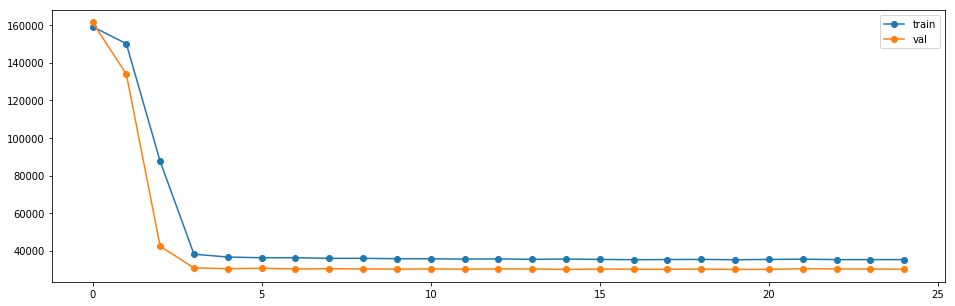

In [19]:
a, b = models[1].get_train_log()

plt.figure(figsize=(16, 5))
plt.plot(a, '-o', label='train')
plt.plot(b, '-o', label='val')
plt.legend()